# Age and Gender Detector 

**Dataset Link: https://www.kaggle.com/datasets/jangedoo/utkface-new**

*Author: Himanshu Atri*

The labels of each face image is embedded in the file name, formated like age_gender_race_date&time.jpg

* age is an integer from 0 to 116, indicating the age

* gender is either 0 (male) or 1 (female)

* race is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).

* date&time is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import random
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Flatten, Dense, MaxPooling2D, Conv2D, BatchNormalization, Input, Activation
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import load_img
from tqdm import tqdm 

2024-07-11 06:31:36.637222: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-11 06:31:36.637329: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-11 06:31:36.777200: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Extracting Data from Dataset

In [2]:
dir = '/kaggle/input/utkface-new/UTKFace' # directory path

In [3]:
files = os.listdir(dir)
print(f"Length: {len(files)}\nName Format: {files[0]}")

Length: 23708
Name Format: 26_0_2_20170104023102422.jpg.chip.jpg


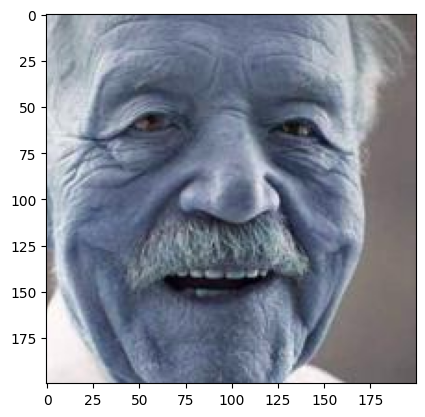

In [4]:
img = cv2.imread('/kaggle/input/utkface-new/UTKFace/100_0_0_20170112213500903.jpg.chip.jpg')
plt.imshow(img)

# Creating List of Data from Dataset (images_path, age and gender)

In [5]:
image_paths = []
age_label = []
gender_label = []

# getting all the file path and label
for file in tqdm(files):
    img_path = os.path.join(dir, file)
    name_split = file.split('_')
    if int(name_split[1]) >= 2 or not name_split[2].isdigit():
        continue
    image_paths.append(img_path)
    age_label.append(int(name_split[0]))
    gender_label.append(int(name_split[1]))

100%|██████████| 23708/23708 [00:00<00:00, 227790.58it/s]


In [6]:
len(image_paths), len(age_label), len(gender_label)

(23705, 23705, 23705)

In [7]:
image_paths[0], age_label[0], gender_label[0]

('/kaggle/input/utkface-new/UTKFace/26_0_2_20170104023102422.jpg.chip.jpg',
 26,
 0)

# Creating Dataframe

In [8]:
df = pd.DataFrame()
df['image_path'] = image_paths
df['age'] = age_label
df['gender'] = gender_label

In [9]:
df.head(-3)

,image_path,age,gender
0,/kaggle/input/utkface-new/UTKFace/26_0_2_20170...,26,0
1,/kaggle/input/utkface-new/UTKFace/22_1_1_20170...,22,1
2,/kaggle/input/utkface-new/UTKFace/21_1_3_20170...,21,1
3,/kaggle/input/utkface-new/UTKFace/28_0_0_20170...,28,0
4,/kaggle/input/utkface-new/UTKFace/17_1_4_20170...,17,1
...,...,...,...
23697,/kaggle/input/utkface-new/UTKFace/66_0_0_20170...,66,0
23698,/kaggle/input/utkface-new/UTKFace/67_0_1_20170...,67,0
23699,/kaggle/input/utkface-new/UTKFace/17_1_1_20170...,17,1
23700,/kaggle/input/utkface-new/UTKFace/41_0_0_20170...,41,0


In [10]:
# gender dictonary
gender_dict = {0: 'Male', 1: 'Female'}

# Visualizing Data

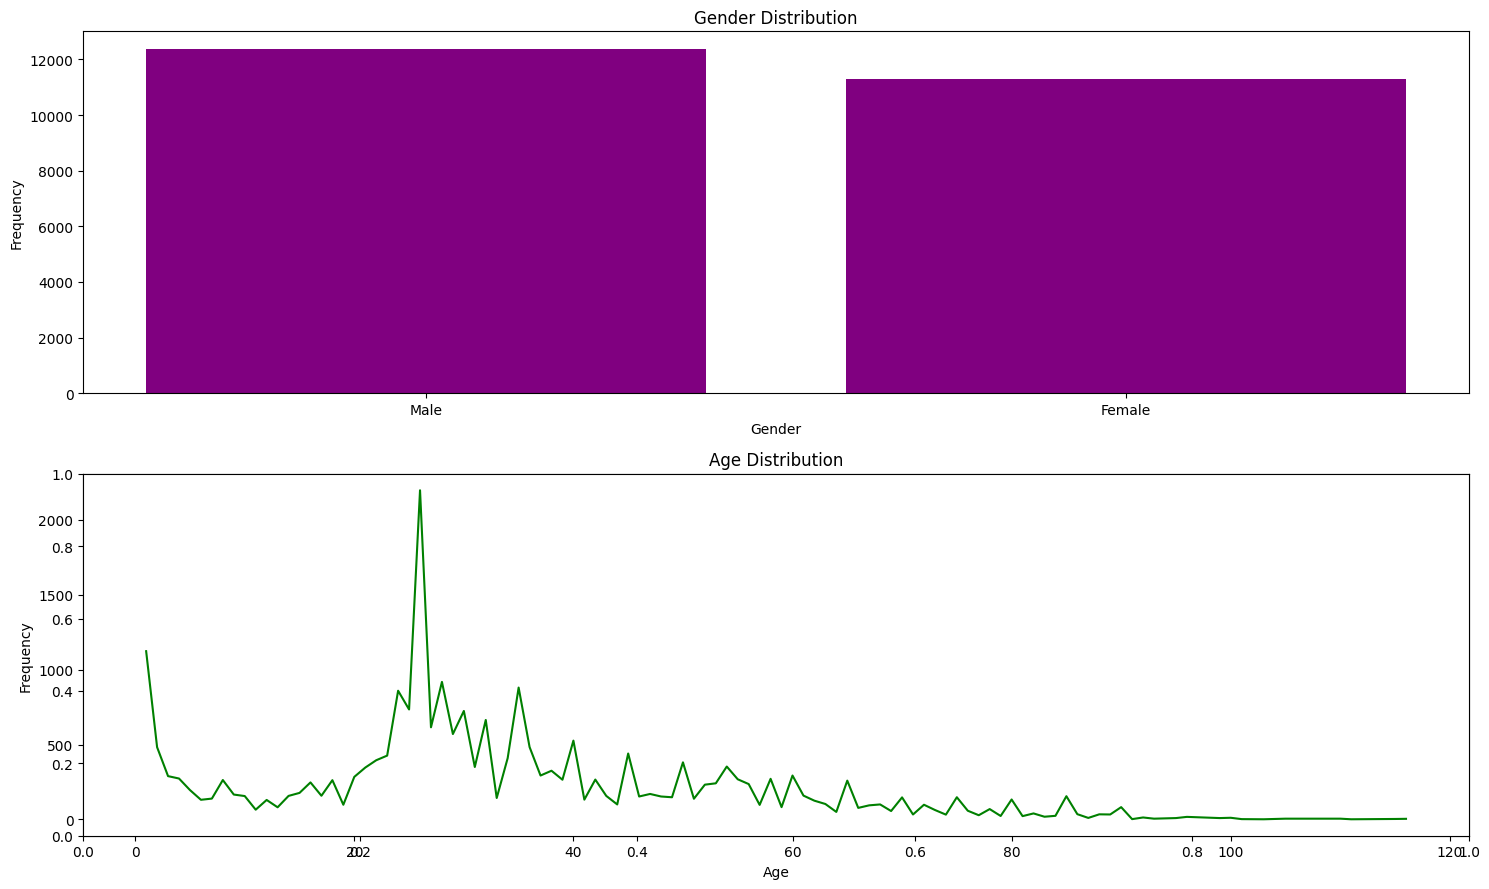

In [11]:
fig, ax = plt.subplots(figsize=(15, 9), nrows=2, ncols=1)
ax[0].bar(['Male', 'Female'], np.unique(df['gender'], return_counts=True)[1], color='purple')
ax[0].set_xlabel("Gender")
ax[0].set_ylabel("Frequency")
ax[0].set_title("Gender Distribution")

ax[1] = fig.add_subplot(212)
ax[1].plot(np.unique(df['age'], return_counts=True)[0], np.unique(df['age'], return_counts=True)[1], color='green')
ax[1].set_xlabel("Age")
ax[1].set_ylabel("Frequency")
ax[1].set_title("Age Distribution")


plt.tight_layout()
fig.show()

# Plotting Random Images

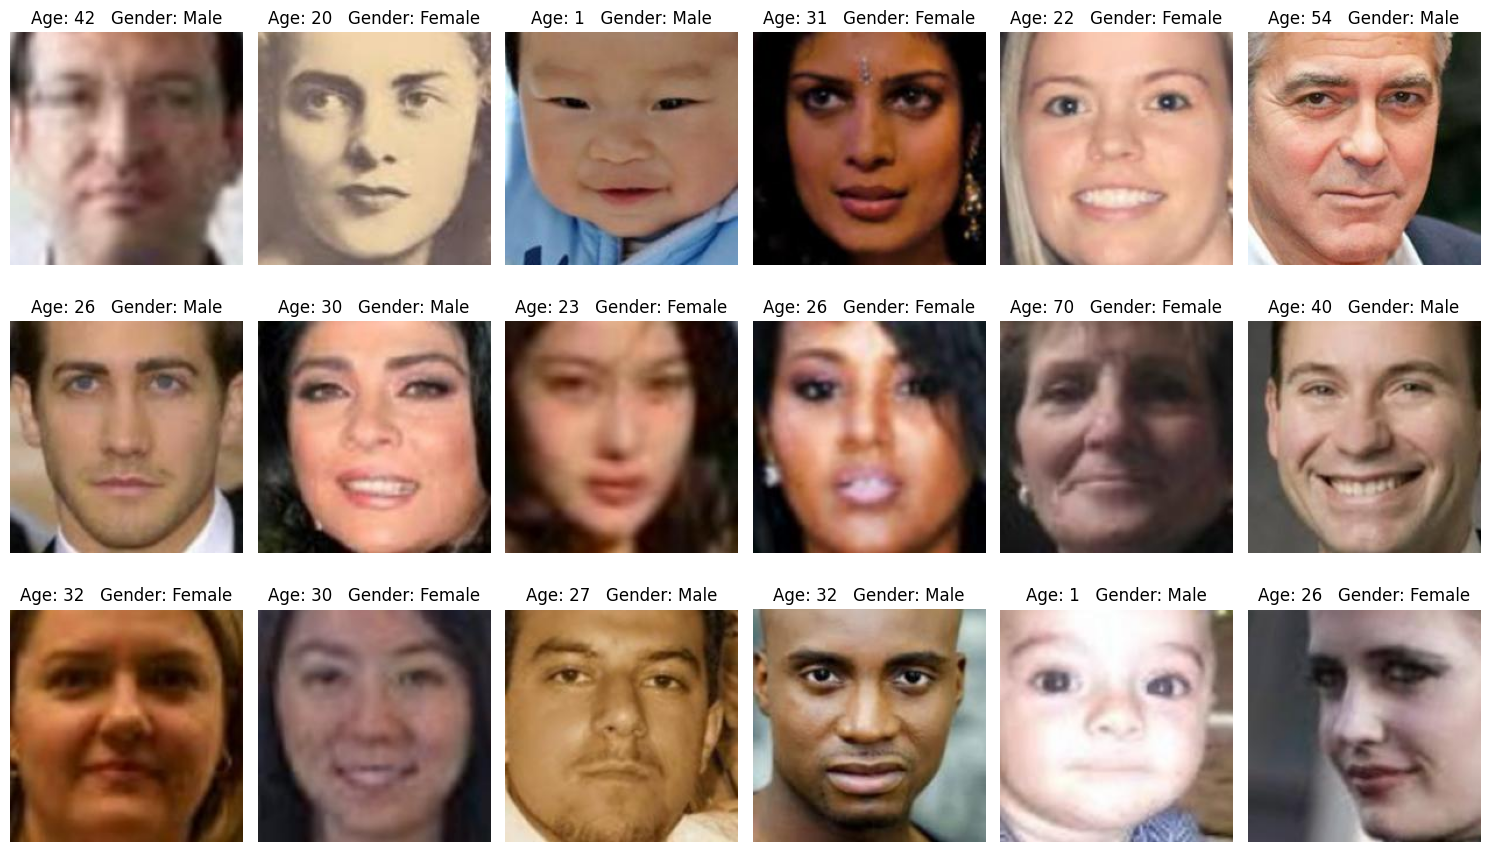

In [12]:
# random images from dataset
plt.figure(figsize=(15, 9))
random_numbers = random.sample(range(0, len(df)), 18)
for x, y in zip(range(1,19), random_numbers):
    img = cv2.imread(df['image_path'][y])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3, 6, x)
    plt.imshow(img)
    temp_age = df['age'][y]
    temp_gender = "Male" if df['gender'][y]==0 else "Female"
    plt.title(f"Age: {temp_age}   Gender: {temp_gender}")
    plt.axis("off")
    
plt.tight_layout()
plt.show()

# Creating X and Y (Input and Output)

In [13]:
X = []
for image_path in tqdm(df['image_path']):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (48,48), interpolation=cv2.INTER_LANCZOS4)
    X.append(img)
    
X = np.array(X, dtype = np.float32)
np.save("/kaggle/working/X_data.npy", X)

100%|██████████| 23705/23705 [02:58<00:00, 132.87it/s]


In [14]:
X = np.load("/kaggle/working/X_data.npy")

In [15]:
X.shape

(23705, 48, 48, 3)

In [16]:
X /= 255.0

In [17]:
Y_gender = np.array(df['gender'])
Y_age = np.array(df['age'])
input_shape = (48,48,3)

In [18]:
Y = []

for gender, age in zip(Y_gender, Y_age):
    Y.append([gender, age])
    
Y = np.array(Y)
Y.shape, Y[0:3]

((23705, 2),
 array([[ 0, 26],
        [ 1, 22],
        [ 1, 21]]))

# Splitting The Data

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=10)

In [20]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape 

((18964, 48, 48, 3), (4741, 48, 48, 3), (18964, 2), (4741, 2))

In [21]:
Y_train = Y_train[:,0], Y_train[:,1]
Y_test = Y_test[:,0], Y_test[:,1]

# Model Architecture

In [22]:
def convolution(input_tensor, filters):
    x=Conv2D(filters=filters,kernel_size=(3,3),padding="same",strides=(1,1),kernel_regularizer=l2(0.001))(input_tensor)
    x=Dropout(0.1)(x)
    x=Activation('relu')(x)
    return x

In [23]:
def model_arch(input_shape):
    inputs = Input((input_shape))
    
    conv_1 = convolution(inputs, 32)
    max_pool_1 = MaxPooling2D(pool_size=(2,2))(conv_1)
    
    conv_2 = convolution(max_pool_1, 64)
    max_pool_2 = MaxPooling2D(pool_size=(2,2))(conv_2)
    
    conv_3 = convolution(max_pool_2, 128)
    max_pool_3 = MaxPooling2D(pool_size=(2,2))(conv_3)
    
    conv_4 = convolution(max_pool_3, 256)
    max_pool_4 = MaxPooling2D(pool_size=(2,2))(conv_4)
    
    flatten = Flatten()(max_pool_4)
    
    dense_1 = Dense(64, activation='relu')(flatten)
    dense_2 = Dense(64, activation='relu')(flatten)
    
    drop_1 = Dropout(0.2)(dense_1)
    drop_2 = Dropout(0.2)(dense_2)
    
    output_1 = Dense(1, activation='sigmoid', name='gender')(drop_1)
    output_2 = Dense(1, activation='relu', name='age')(drop_2)
    
    model = Model(inputs=[inputs], outputs=[output_1, output_2])
    model.compile(loss=["binary_crossentropy", "mae"], optimizer='Adam', metrics=["accuracy", "mae"])
    
    return model
    

In [24]:
model= model_arch(input_shape)

In [25]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 48, 48,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 48, 48,    │          0 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 48, 48,    │          0 │ dropout[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 24, 24,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 24, 24,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 24, 24,    │          0 │ conv2d_1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 24, 24,    │          0 │ dropout_1[0][0]   │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 12, 12,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 12, 12,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 12, 12,    │          0 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 12, 12,    │          0 │ dropout_2[0][0]   │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 6, 6, 128) │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 6, 6, 256) │    295,168 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 6, 6, 256) │          0 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 6, 6, 256) │          0 │ dropout_3[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 3, 3, 256) │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 683,586 (2.61 MB)

 Trainable params: 683,586 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model_file = 'Age_Gender_Detector.keras'
checkpoint = ModelCheckpoint(model_file, monitor='val_age_mae', save_best_only=True, verbose=1, save_weights_only=False, mode='min', save_freq='epoch')
early_stopping = EarlyStopping(patience=25, monitor='val_age_mae', restore_best_weights=True, mode='min')
callback_list = [checkpoint, early_stopping]

# Training the Model

In [27]:
history = model.fit(X_train, Y_train, batch_size=64, validation_data=[X_test, Y_test], epochs=250, callbacks=callback_list)

Epoch 1/250


2024-07-11 06:35:07.952489: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2304: 4.34183, expected 3.61488
2024-07-11 06:35:07.952543: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2305: 5.83686, expected 5.1099
2024-07-11 06:35:07.952552: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2306: 4.82442, expected 4.09746
2024-07-11 06:35:07.952560: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2307: 4.63712, expected 3.91017
2024-07-11 06:35:07.952567: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2308: 4.36758, expected 3.64062
2024-07-11 06:35:07.952575: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2309: 5.45394, expected 4.72698
2024-07-11 06:35:07.952583: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2310: 5.20225, expected 4.47529
2024-07-11 06:35:07.952590: E exter

 21/297 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - age_mae: 26.8063 - gender_accuracy: 0.4791 - loss: 27.8588

I0000 00:00:1720679714.556000      73 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1720679714.576371      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


292/297 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - age_mae: 18.2431 - gender_accuracy: 0.5243 - loss: 19.1640

2024-07-11 06:35:21.771588: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6912: 4.69159, expected 4.1195
2024-07-11 06:35:21.771649: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6921: 4.16969, expected 3.59759
2024-07-11 06:35:21.771664: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6922: 4.48734, expected 3.91525
2024-07-11 06:35:21.771677: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6943: 4.64299, expected 4.07089
2024-07-11 06:35:21.771688: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6944: 4.64865, expected 4.07656
2024-07-11 06:35:21.771702: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7584: 4.43019, expected 3.8581
2024-07-11 06:35:21.771717: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8304: 4.42803, expected 3.85594
2024-07-11 06:35:21.771732: E extern

297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - age_mae: 18.2098 - gender_accuracy: 0.5248 - loss: 19.1299

2024-07-11 06:35:30.442118: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2304: 4.34183, expected 3.61488
2024-07-11 06:35:30.442177: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2305: 5.83686, expected 5.1099
2024-07-11 06:35:30.442186: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2306: 4.82442, expected 4.09746
2024-07-11 06:35:30.442194: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2307: 4.63712, expected 3.91017
2024-07-11 06:35:30.442202: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2308: 4.36758, expected 3.64062
2024-07-11 06:35:30.442210: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2309: 5.45394, expected 4.72698
2024-07-11 06:35:30.442217: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2310: 5.20225, expected 4.47529
2024-07-11 06:35:30.442225: E exter


Epoch 1: val_age_mae improved from inf to 28.15177, saving model to Age_Gender_Detector.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 32s 60ms/step - age_mae: 18.2033 - gender_accuracy: 0.5249 - loss: 19.1232 - val_age_mae: 28.1518 - val_gender_accuracy: 0.6560 - val_loss: 28.9593
Epoch 2/250
294/297 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - age_mae: 14.0630 - gender_accuracy: 0.6188 - loss: 14.8735
Epoch 2: val_age_mae improved from 28.15177 to 20.95452, saving model to Age_Gender_Detector.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - age_mae: 14.0541 - gender_accuracy: 0.6193 - loss: 14.8646 - val_age_mae: 20.9545 - val_gender_accuracy: 0.6648 - val_loss: 21.7843
Epoch 3/250
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - age_mae: 10.8281 - gender_accuracy: 0.7191 - loss: 11.6253
Epoch 3: val_age_mae improved from 20.95452 to 15.68296, saving model to Age_Gender_Detector.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - age_mae: 10.8261 - gender_accuracy: 0.7193 - loss: 11.6232 - val_age_mae: 15.6830 - 

In [28]:
from tensorflow.keras.models import load_model
model = load_model("/kaggle/working/Age_Gender_Detector.keras")

In [29]:
model.evaluate(X_test, Y_test)

2024-07-11 06:36:43.725056: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6911: 2.24278, expected 1.90742
2024-07-11 06:36:43.725126: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9216: 3.89406, expected 3.21433
2024-07-11 06:36:43.725135: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9217: 5.04352, expected 4.36379
2024-07-11 06:36:43.725143: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9218: 4.6108, expected 3.93107
2024-07-11 06:36:43.725151: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9219: 4.0859, expected 3.40618
2024-07-11 06:36:43.725159: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9220: 4.0417, expected 3.36198
2024-07-11 06:36:43.725167: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9221: 4.96818, expected 4.28845
2024-07-11 06:36:43.725175: E externa

149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - age_mae: 11.5755 - gender_accuracy: 0.7801 - loss: 12.3651


[12.281039237976074, 11.499103546142578, 0.7852773666381836]

# Evaluating Model Performance

In [30]:
predictions = model.predict(X_test)

149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [31]:
predictions[0][0:3], predictions[1][0:3]

(array([[0.9975182],
        [0.7930345],
        [0.9905288]], dtype=float32),
 array([[34.33057 ],
        [29.389708],
        [45.96818 ]], dtype=float32))

In [32]:
gender_pred = []

for i in predictions[0]:
    gender_pred.append(int(np.round(i)))

In [33]:
report = classification_report(Y_test[0], gender_pred)
print(report)


              precision    recall  f1-score   support

           0       0.85      0.73      0.78      2510
           1       0.73      0.85      0.79      2231

    accuracy                           0.79      4741
   macro avg       0.79      0.79      0.79      4741
weighted avg       0.79      0.79      0.79      4741



In [34]:
results = confusion_matrix(Y_test[0], gender_pred)
print(results)

[[1826  684]
 [ 334 1897]]


# Plottting Model Performance

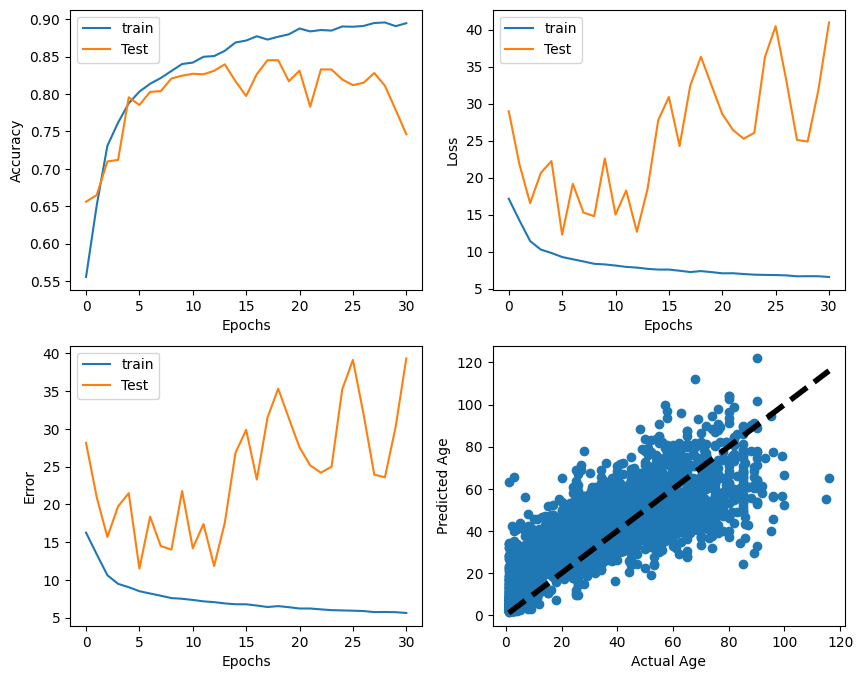

In [35]:
fig, ax = plt.subplots(figsize=(10, 8), nrows=2, ncols=2)

ax[0][0].plot(history.history['gender_accuracy'])
ax[0][0].plot(history.history['val_gender_accuracy'])
ax[0][0].set_xlabel("Epochs")
ax[0][0].set_ylabel("Accuracy")
ax[0][0].legend(["train", "Test"])

ax[0][1].plot(history.history['loss'])
ax[0][1].plot(history.history['val_loss'])
ax[0][1].set_xlabel("Epochs")
ax[0][1].set_ylabel("Loss")
ax[0][1].legend(["train", "Test"])


ax[1][0].plot(history.history['age_mae'])
ax[1][0].plot(history.history['val_age_mae'])
ax[1][0].set_xlabel("Epochs")
ax[1][0].set_ylabel("Error")
ax[1][0].legend(["train", "Test"])

ax[1][1].scatter(Y_test[1], predictions[1])
ax[1][1].plot([Y_test[1].min(), Y_test[1].max()], [Y_test[1].min(), Y_test[1].max()], 'k--',lw=4)
ax[1][1].set_xlabel("Actual Age")
ax[1][1].set_ylabel("Predicted Age")

fig.show()

<Axes: >

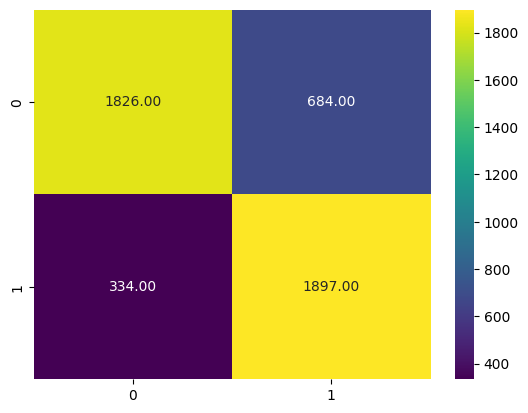

In [36]:
sns.heatmap(results,annot=True, fmt=".2f", cmap="viridis")

# Making Predictions

In [37]:
def predict_age_gender(img_index):
    if(img_index >= len(df)):
        print("Index exceeded the length")
        return 
    
    img_path = df['image_path'][img_index]
    img_gender = gender_dict[df['gender'][img_index]]
    img_age = df['age'][img_index]
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img_resize = cv2.resize(img, (48,48), interpolation=cv2.INTER_LANCZOS4)
    
    # Add batch dimension
    img_resize = np.expand_dims(img_resize, axis=0)
    img_input = img_resize / 255.0
    
    img_input = img_resize / 255.0
    
    my_pred = model.predict(img_input)
    
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.axis("off")
    pred_gender = gender_dict[int(np.round(my_pred[0][0][0]))]
    pred_age = int(np.round(my_pred[1][0][0]))
    plt.title(f"Original Gender: {img_gender} Original Age: {img_age}\nPredicted Gender: {pred_gender} Predicted Age: {pred_age}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


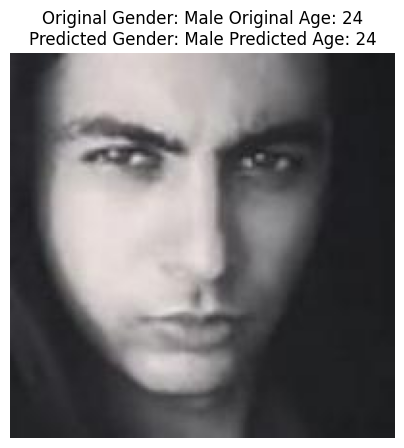

In [38]:
predict_age_gender(1000)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


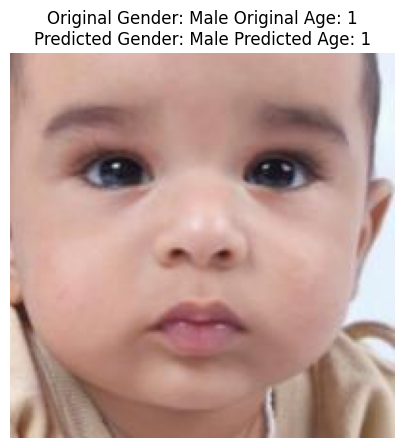

In [39]:
predict_age_gender(69)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


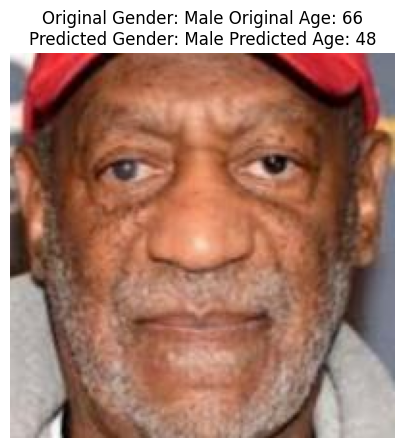

In [40]:
predict_age_gender(23704)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


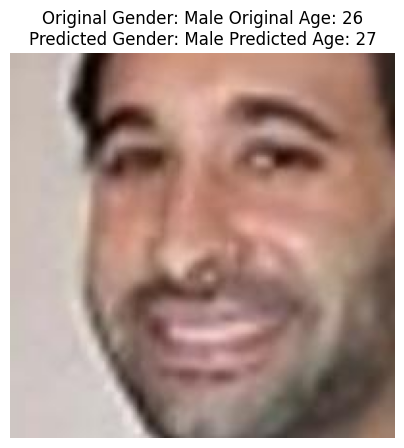

In [41]:
predict_age_gender(15000)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


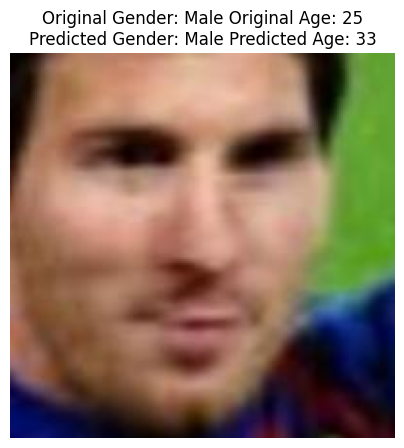

In [42]:
predict_age_gender(8000)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


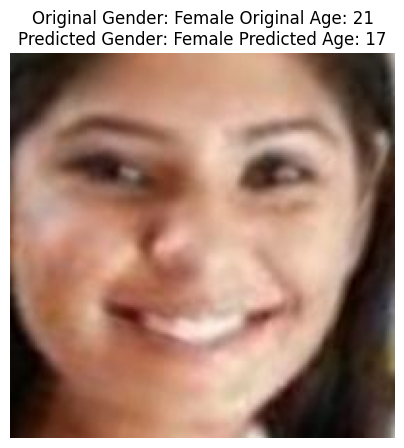

In [43]:
predict_age_gender(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


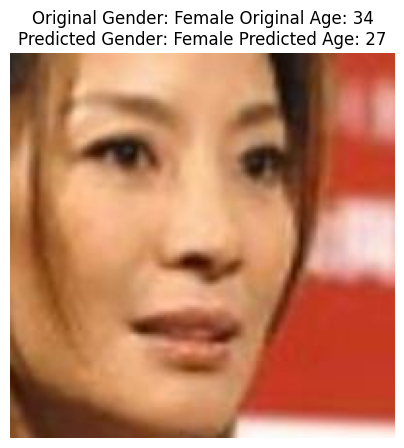

In [44]:
predict_age_gender(22111)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


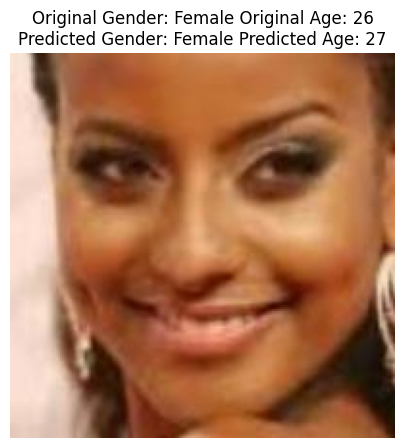

In [45]:
predict_age_gender(23010)